In [1]:
import pandas as pd
import numpy as np
import csv
import os
from scipy import stats
import pyphysio as ph
from pdb import set_trace
import random
from datetime import timedelta, datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Using dask. Scheduler: threads
Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [2]:
#survey windows 
#these are available in the 10 Minute Windows subfolder
surv = pd.read_csv('/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/10 Minute Windows/PR003/PR003 Survey Windows MERGED.csv',parse_dates=['timestamp'], infer_datetime_format=True, index_col=[0])

#baseline windows
#also available in the 10 Minute Windows subfolder
base = pd.read_csv('/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/10 Minute Windows/PR003/PR003 Baseline MERGED.csv',parse_dates=['timestamp'], infer_datetime_format=True, index_col=[0])

#ema responses
#found in Sofie Data subfolder, may have to dig for it 
ema = pd.read_csv("/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/Data/Sofie Data/PR/Maintained active dx/PR003/PR003_rawwithtime2022-07-03.csv", parse_dates=['ethica_time_utc'], infer_datetime_format=True, index_col=[0])

In [3]:
### these scripts are taken from prior scripts written by collaborators with some modification by me
### these are all the functions we need... i think

#Preprocessing filters that will be applied to raw data samples
def exp_moving_average(signal, w):
    """Expoential moving average filter from pandas"""
    return pd.Series(signal.ewm(span=w, adjust=True).mean(), signal.index)

def filt_EDA(df_data):
    """Apply filter to EDA signal using processing steps from Pyphysio.
    
    Parameters
    ----------
    df_data : pandas.DataFrame
        DataFrame with EDA time and signal data
    
    Returns
    -------
    pandas.DataFrame 
        Updated DataFrame with Tonic and Phasic signals
    
    """
    
    # Set up Pyphysio EvenlySignal object
    eda_data = ph.EvenlySignal(values = df_data['EDA'].to_numpy(), sampling_freq = 4, signal_type='EDA')
    
    # Apply IIR filter
    eda_data = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda_data)
    driver = ph.DriverEstim()(eda_data)
    
    # Estimate Tonic and Phasic signals
    phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)
    
    # Adjust signal length to match length of original EDA signal
    if len(phasic) != len(eda_data.get_values()):
        phasic = np.append(phasic.get_values(), phasic[-1])
        tonic = np.append(tonic.get_values(), tonic[-1])    
    
    # Append signal data to DataFrame
    df_data.loc[:,'Tonic'] = tonic
    df_data.loc[:,'Phasic'] = phasic
    return df_data  

def filt_TEMP(df_data):
    """Apply filter to TEMP signal using predetermined values"""
    df_data['TEMP_Filtered'] = exp_moving_average(df_data['TEMP'],60)
    return df_data

def filter_signals(df_data):
    """Apply filters/processing to respective signals.
    
    This function is intended to be used in conjunction with the
    pandas.DataFrame.apply() method, which passes a column of a DataFrame at
    a time.
    
    Parameters
    ----------
    df_data : pandas.Series
        A Series of DataFrames which contain all the signals for a single
        session.
    
    Returns
    -------
    pandas.Series
        Updated Series of DataFrames containing filtered/processed signal
        data
        
    Notes
    -----
    No filtering/processing for ACC, HR, and IBI signals is implemented,
    but is commented out for implementation in the future.
    
    """
    
    #df_data.loc['BVP'].loc[:,'BVP'] = filt_BVP(df_data.loc['BVP'])
    df_data = filt_EDA(df_data)
    df_data = filt_TEMP(df_data)
    
    return df_data


#RMS calculation Helper Function
def rms(data):
    return np.sqrt(np.mean(data ** 2))

#Every other feature is easy to calculate using Python built-ins
def feature_extract(df_data):
    result = {}
    result['Time'] = df_data.loc[:,'timestamp'].min()
    #for featbase in ['HR','EDA','TEMP','Tonic','Phasic','TEMP_Filtered']:
    for featbase in ['HR','EDA','TEMP', 'meanCenteredEDA', 'meanCenteredHR', 'meanCenteredTEMP']:
        #set_trace()
        result[featbase + '_Mean'] = df_data.loc[:,featbase].mean()
        result[featbase + '_Minimum'] = df_data.loc[:,featbase].min()
        result[featbase + '_Maximum'] = df_data.loc[:,featbase].max()
        result[featbase + '_Stdev'] = df_data.loc[:,featbase].std()
        result[featbase + '_RMS'] = rms(df_data.loc[:,featbase])
        result[featbase + '_MAD'] = df_data.loc[:,featbase].mad()
        result[featbase + '_MAV'] = df_data.loc[:,featbase].abs().max()
        result[featbase + '_Median'] = df_data.loc[:,featbase].median()
        result[featbase + '_P25'] = df_data.loc[:,featbase].quantile(0.25)
        result[featbase + '_P75'] = df_data.loc[:,featbase].quantile(0.75)
    return pd.Series(result, dtype='object')


#simplified the feature extraction function to only grab mean and median
def average_calc(df_data):
    result = {}    
    result['EDA_Mean'] = df_data.loc[:,'EDA'].mean()
    result['EDA_Median'] = df_data.loc[:,'EDA'].median()
    result['HR_Mean'] = df_data.loc[:,'HR'].mean()
    result['HR_Median'] = df_data.loc[:,'HR'].median()
    result['TEMP_Mean'] = df_data.loc[:,'TEMP'].mean()
    result['TEMP_Median'] = df_data.loc[:,'TEMP'].median()

    return pd.Series(result, dtype='object')

#creating a function to match rows
#remember that the physio timestamp must ALWAYS BE BEFORE the EMA timestamp

def windowMatch(features,surveys): 
    matchlist = []
    for index, frow in features.iterrows():
        physiotime = frow['Time']
        for index, srow in surveys.iterrows():
            ematime = srow['ethica_time_utc']
            df3 = ematime - physiotime
            if df3 < delta and df3 > zeropoint:
                #print("Physio time (", physiotime, ") and EMA time (", ematime, ") difference is", df3)
                matchlist.append(pd.concat([frow,srow],axis=0))
    return pd.DataFrame(matchlist)

In [4]:
#this chunk of code will normalize our date (deducting the average/median of the baseline windows from each datapoint in survey windows)

baseline_values = base.groupby(['code']).apply(average_calc) # calculating averages of the baseline

#creating variables to subtract from the dataframe columns
edamean = baseline_values.at[0,"EDA_Mean"]
edamed = baseline_values.at[0,"EDA_Median"]
hrmean = baseline_values.at[0,"HR_Mean"]
hrmed = baseline_values.at[0,"HR_Median"]
tempmean = baseline_values.at[0,"TEMP_Mean"]
tempmed = baseline_values.at[0,"TEMP_Median"]

#subtracting our means/medians from each value in the participant's data - excluding ACC 
surv['meanCenteredEDA'] = surv['EDA'] - edamean
surv['medianCenteredEDA'] = surv['EDA'] - edamed
surv['meanCenteredHR'] = surv['HR'] - hrmean
surv['medianCenteredHR'] = surv['HR'] - hrmed
surv['meanCenteredTEMP'] = surv['TEMP'] - tempmean
surv['medianCenteredTEMP'] = surv['TEMP'] - tempmed

surv.head()

,timestamp,HR,X,Y,Z,TEMP,BVP,EDA,event,meanCenteredEDA,medianCenteredEDA,meanCenteredHR,medianCenteredHR,meanCenteredTEMP,medianCenteredTEMP
timer,,,,,,,,,,,,,,,
0.25,2020-11-09 13:58:00.000,77.60,10.0,-59.0,12.0,25.69,1.55,0.155013,118,0.058004,0.088396,21.709047,28.21,-2.200798,-3.42
0.50,2020-11-09 13:58:00.250,77.53,3.0,-83.0,22.0,25.69,270.52,0.153732,118,0.056723,0.087115,21.639047,28.14,-2.200798,-3.42
0.75,2020-11-09 13:58:00.500,77.53,19.0,-60.0,17.0,25.69,67.38,0.155013,118,0.058004,0.088396,21.639047,28.14,-2.200798,-3.42
1.00,2020-11-09 13:58:00.750,77.53,16.0,-61.0,24.0,25.69,141.72,0.153732,118,0.056723,0.087115,21.639047,28.14,-2.200798,-3.42
1.25,2020-11-09 13:58:01.000,77.53,4.0,-65.0,19.0,25.67,-110.51,0.156294,118,0.059285,0.089677,21.639047,28.14,-2.220798,-3.44


In [5]:
#this chunk is to prepare the physio data to be matched to timestamps 

physio = surv.sort_values(['timestamp'], ignore_index=True) #sort by timestamp
physio = physio.groupby(['event']).apply(feature_extract) #applying feature extraction to create summary features

#setting up a timedelta to base our window matching off of
#a survey window can never occur more than an hour from when a survey was completed, so our delta is 1 hour
#if a window is more than an hour separate from survey completion, it cannot be matched
#however, the survey window timestamp should ALWAYS precede the survey completion time
delta = timedelta(hours = 1)
zeropoint = timedelta(seconds = 1)

#now we apply the window matching function - it calculates the time differences of each timestamp
#if the time difference is less than 1 hour, match the windows together
mydf = windowMatch(physio, ema)
for index,row in mydf.iterrows():
    print (abs(row['ethica_time_utc']-row['Time']))
    
mydf.head()

0 days 00:13:20
0 days 00:14:30
0 days 00:14:37
0 days 00:13:03
0 days 00:13:33
0 days 00:13:27
0 days 00:13:36
0 days 00:21:52
0 days 00:14:31
0 days 00:18:24
0 days 00:14:22
0 days 00:16:54
0 days 00:12:52
0 days 00:12:59
0 days 00:15:57
0 days 00:13:47
0 days 00:14:41
0 days 00:02:34
0 days 00:14:53
0 days 00:14:34
0 days 00:26:53
0 days 00:12:49
0 days 00:14:12
0 days 00:14:38
0 days 00:17:15
0 days 00:14:35
0 days 00:03:24.750000
0 days 00:18:43
0 days 00:14:44
0 days 00:14:20
0 days 00:34:53
0 days 00:15:08
0 days 00:15:52
0 days 00:13:31
0 days 00:13:57
0 days 00:14:28
0 days 00:16:41
0 days 00:13:12
0 days 00:15:03
0 days 00:14:09
0 days 00:14:17
0 days 00:13:07
0 days 00:14:02
0 days 00:15:46
0 days 00:13:45
0 days 00:12:06
0 days 00:13:24
0 days 00:14:56
0 days 00:17:11
0 days 00:12:53
0 days 00:12:48
0 days 00:16:32
0 days 00:19:19
0 days 00:15:07
0 days 00:12:44
0 days 00:15:23
0 days 00:14:44
0 days 00:16:57
0 days 00:13:07
0 days 00:22:16
0 days 00:15:04
0 days 00:14:23
0

,Time,HR_Mean,HR_Minimum,HR_Maximum,HR_Stdev,HR_RMS,HR_MAD,HR_MAV,HR_Median,HR_P25,...,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit
0,2020-12-09 14:54:00,88.744522,73.17,103.47,6.505839,88.982574,5.464294,103.47,89.37,83.67,...,0.0,90.0,0.0,81.0,85.0,0.0,78.0,60.0,85.0,0.0
1,2020-12-09 00:24:00,79.124461,51.55,107.33,14.197488,80.387592,11.629135,107.33,78.45,70.92,...,0.0,84.0,0.0,78.0,82.0,0.0,78.0,81.0,66.0,0.0
2,2020-12-08 19:30:00,66.492599,54.12,88.70,8.862043,67.080316,6.977266,88.70,64.57,60.28,...,0.0,89.0,83.0,78.0,87.0,0.0,78.0,71.0,77.0,0.0
3,2020-12-08 17:59:00,60.827888,47.20,73.68,5.746152,61.098580,4.684614,73.68,61.47,56.02,...,0.0,83.0,85.0,86.0,88.0,0.0,80.0,80.0,77.0,0.0
4,2020-12-07 22:58:00,52.120404,40.58,66.08,5.952649,52.459087,4.719678,66.08,51.93,48.53,...,0.0,88.0,77.0,76.0,74.0,0.0,77.0,79.0,76.0,0.0


In [6]:
#putting together physio featureset to be ready for correlations
featbase =['HR','EDA','TEMP', 'meanCenteredEDA', 'meanCenteredHR', 'meanCenteredTEMP']
featstat =['_Mean','_Minimum','_Stdev','_RMS','_MAD','_MAV','_Median','_P25','_P75']
physio_feats = {}
allfeats = []
for fb in featbase:
    curfeats=[]
    for fs in featstat:
        curfeats.append(fb+fs)
        allfeats.append(fb+fs)
    physio_feats[fb] = mydf[curfeats]
physio_feats['All'] = mydf[allfeats]
        

In [61]:
#cleaning up EMA dataset for correlations
excl_list = ['ethica_time','lag','tdif','cumsumT','ethica_time_utc','dayvar','beepvar','beepconsec']
surfeat=[ele for ele in list(ema.columns) if ele not in excl_list]
ema_feats = mydf[surfeat]

In [62]:
#centering EMA just in case - just hashtag out this loop if it's not necessary

for col in ema_feats:
    ema_feats[col + '_meanCentered'] = ema_feats[col] - ema_feats.loc[:,col].mean()
    ema_feats[col + '_medCentered'] = ema_feats[col] - ema_feats.loc[:,col].median()
    
    
pd.set_option('display.max_columns', None)
ema_feats

<ipython-input-62-6393ea3e0ce2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_feats[col + '_meanCentered'] = ema_feats[col] - ema_feats.loc[:,col].mean()
<ipython-input-62-6393ea3e0ce2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_feats[col + '_medCentered'] = ema_feats[col] - ema_feats.loc[:,col].median()
<ipython-input-62-6393ea3e0ce2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,overvalwtsh,reject,mistakes,highstand,iuc,saa,intrus_thought,fearloc,bodydiss,ineffective,food_intrus,guilty,shame,sad,si,thought_death,scared,feelfat,tired,agitated,relax,urge_restrict,stress,skipmeal,foodrules,vomit,laxdiur,binge,bodycheck,impulse,exercise,compulsion,avoid_food,selfharm,hunger_anx,smallportion,drink_public,avoid_emo,avoid_sit,emo_overwhelm,eat_anx,rumination,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit,sleep_meanCentered,sleep_medCentered,fowg_meanCentered,fowg_medCentered,wtshdiss_meanCentered,wtshdiss_medCentered,badperson_meanCentered,badperson_medCentered,eat_public_meanCentered,eat_public_medCentered,eat_worry_meanCentered,eat_worry_medCentered,anxiety_meanCentered,anxiety_medCentered,worthless_meanCentered,worthless_medCentered,restrict_meanCentered,restrict_medCentered,desirethin_meanCentered,desirethin_medCentered,overvalwtsh_meanCentered,overvalwtsh_medCentered,reject_meanCentered,reject_medCentered,mistakes_meanCentered,mistakes_medCentered,highstand_meanCentered,highstand_medCentered,iuc_meanCentered,iuc_medCentered,saa_meanCentered,saa_medCentered,intrus_thought_meanCentered,intrus_thought_medCentered,fearloc_meanCentered,fearloc_medCentered,bodydiss_meanCentered,bodydiss_medCentered,ineffective_meanCentered,ineffective_medCentered,food_intrus_meanCentered,food_intrus_medCentered,guilty_meanCentered,guilty_medCentered,shame_meanCentered,shame_medCentered,sad_meanCentered,sad_medCentered,si_meanCentered,si_medCentered,thought_death_meanCentered,thought_death_medCentered,scared_meanCentered,scared_medCentered,feelfat_meanCentered,feelfat_medCentered,tired_meanCentered,tired_medCentered,agitated_meanCentered,agitated_medCentered,relax_meanCentered,relax_medCentered,urge_restrict_meanCentered,urge_restrict_medCentered,stress_meanCentered,stress_medCentered,skipmeal_meanCentered,skipmeal_medCentered,foodrules_meanCentered,foodrules_medCentered,vomit_meanCentered,vomit_medCentered,laxdiur_meanCentered,laxdiur_medCentered,binge_meanCentered,binge_medCentered,bodycheck_meanCentered,bodycheck_medCentered,impulse_meanCentered,impulse_medCentered,exercise_meanCentered,exercise_medCentered,compulsion_meanCentered,compulsion_medCentered,avoid_food_meanCentered,avoid_food_medCentered,selfharm_meanCentered,selfharm_medCentered,hunger_anx_meanCentered,hunger_anx_medCentered,smallportion_meanCentered,smallportion_medCentered,drink_public_meanCentered,drink_public_medCentered,avoid_emo_meanCentered,avoid_emo_medCentered,avoid_sit_meanCentered,avoid_sit_medCentered,emo_overwhelm_meanCentered,emo_overwhelm_medCentered,eat_anx_meanCentered,eat_anx_medCentered,rumination_meanCentered,rumination_medCentered,heartrace_meanCentered,heartrace_medCentered,physsens_eat_meanCentered,physsens_eat_medCentered,attn_others_meanCentered,attn_others_medCentered,worryoverwhelm_meanCentered,worryoverwhelm_medCentered,physsens_meanCentered,physsens_medCentered,socialanx_meanCentered,socialanx_medCentered,sens_body_meanCentered,sens_body_medCentered,ridthoughts_meanCentered,ridthoughts_medCentered,memories_meanCentered,memories_medCentered,chewspit_meanCentered,chewspit_medCentered
0,0.0,83.0,76.0,0.0,84.0,88.0,92.0,0.0,84.0,85.0,90.0,82.0,91.0,74.0,80.0,84.0,85.0,74.0,78.0,81.0,87.0,55.0,0.0,81.0,0.0,0.0,71.0,74.0,77.0,31.0,83.0,88.0,85.0,92.0,83.0,0.0,0.0,0.0,85.0,80.0,85.0,81.0,89.0,0.0,85.0,89.0,0.0,68.0,0.0,67.0,84.0,78.0,0.0,90.0,0.0,81.0,85.0,0.0,78.0,60.0,85.0,0.0,-20.165217,-16.0,-3.25641,-3.0,-3.40678,-5.0,-1.288136,0.0,3.29661,3.0,4.745763,4.0,9.194915,9.0,-37.338983,-25.5,-0.491525,-1.0,4.550847,3.0,7.669492,7.0,9.470085,4.0,8.854701,8.0,-8.59322,-9.0,5.042373,5.0,42.70339,33.0,30.076271,11.0,5.533898,0.5,8.194915,3.0,37.456897,46.5,6.222222,4.0,33.872881,55.0,-18.466102,0.0,9.101695,4.5,0.0,0.0,0.0,0.0,30.632479,36.0,-1.452991,-3.0,-1.384615,-1.0,-32.17094,-40.0,-2.25423

In [8]:
#now we're correlating physio with EMA here
corrdict = {}
for sur in surfeat:
    corrdict[sur]=physio_feats['All'].corrwith(ema_feats[sur],method='pearson')
    corrdict[sur]=physio_feats['All'].corrwith(ema_feats[sur],method='pearson')
corr_df = pd.DataFrame(corrdict)
                                                     
corr_df

,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,...,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit
HR_Mean,0.132544,-0.022360,-0.327427,-0.133053,-0.028861,0.084732,-0.069293,-0.059145,-0.045946,-0.010365,...,0.041538,-0.023923,-0.187205,-0.216303,-0.061864,-0.009624,-0.035584,-0.029109,-0.140720,NaN
HR_Minimum,0.050298,-0.008543,-0.192665,-0.173263,-0.029374,0.169663,0.079592,-0.057715,0.015573,0.056019,...,0.052982,0.011837,-0.194714,-0.037389,0.062814,0.015220,0.013702,0.057571,-0.015722,NaN
HR_Stdev,0.014028,0.044701,-0.064308,0.029493,0.095904,0.038349,-0.110788,0.175584,-0.073413,-0.008610,...,0.055607,-0.112569,0.094195,-0.084804,-0.119254,-0.000057,-0.066018,0.048712,0.032674,NaN
HR_RMS,0.128860,-0.017900,-0.321822,-0.128789,-0.022226,0.087880,-0.070745,-0.047642,-0.048723,-0.010096,...,0.045754,-0.030209,-0.177071,-0.214903,-0.067241,-0.009100,-0.036826,-0.024003,-0.133881,NaN
HR_MAD,0.028359,0.028726,-0.034339,0.047629,0.097993,0.044225,-0.121700,0.203836,-0.068157,0.003696,...,0.090277,-0.099059,0.091733,-0.054081,-0.107314,0.020349,-0.071631,0.066884,0.053681,NaN
HR_MAV,0.018366,0.037279,-0.201527,-0.093428,0.073271,0.126725,-0.048003,0.048558,-0.053868,0.005484,...,0.026113,-0.087679,-0.047265,-0.118563,-0.039556,0.006842,-0.043470,0.060805,-0.004698,NaN
HR_Median,0.154231,-0.020366,-0.349207,-0.101778,-0.052304,0.061487,-0.091158,-0.081874,-0.029907,-0.012907,...,0.047644,-0.000687,-0.194860,-0.238818,-0.070818,-0.032756,-0.033643,-0.033307,-0.172253,NaN
HR_P25,0.135414,-0.045988,-0.363256,-0.160427,-0.054187,0.060519,-0.041136,-0.139538,-0.040989,-0.030177,...,-0.017028,0.001891,-0.204338,-0.237058,-0.048257,-0.020381,-0.017980,-0.071068,-0.182496,NaN
HR_P75,0.150049,-0.030377,-0.312661,-0.101329,-0.032039,0.050368,-0.144704,-0.008191,-0.066481,-0.020992,...,0.094110,-0.021882,-0.186859,-0.232348,-0.113797,0.002692,-0.049775,-0.030579,-0.134148,NaN
EDA_Mean,0.021741,0.036491,-0.186620,-0.057461,0.043877,0.236585,0.169382,-0.076000,0.028171,0.082092,...,-0.017859,-0.009446,-0.193529,-0.071065,0.079555,0.029683,0.139631,0.108681,0.006980,NaN


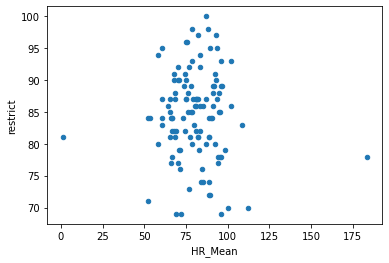

In [15]:
#just in case you want to do some scatterplots 
#you'll notice a lot of outliers in some of these plots - we may want to establish some way to remove outliers - perhaps if something is 4+ SDs from the mean?
ax1= mydf.plot.scatter(x='HR_Mean',y='restrict')

In [13]:
#/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/JPCS Special Issue/normalizing.ipynb

#this will save the centered survey windows
surv.to_csv("""/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/JPCS Special Issue/Normalized Data/PR003 Survey Windows CENTERED.csv""")

#this will save our correlation matrix 
corr_df.to_csv("""/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/JPCS Special Issue/Correlation Matrices/PR003 Survey Correlations.csv""")

